# PHYS 321 Coding Lab #6: Bayesian Model Selection with the Hulse-Taylor Binary

In this Coding Lab, we use data from the Hulse-Taylor binary system to get more familiar with the concepts of marginalization and Bayesian model selection.

In [165]:
import numpy as np

## Background

Recall that the Hulse-Taylor binary system is a binary system consisting of two neutron stars, one of which is a pulsar:

<div>
<img src="images/binpulse.gif" width="400">
</div>

As the pulsar rotates about its own axis, radio emission is emitted in beams, and when these beams intersect the Earth, we get a brief "pulse" at our radio telescope. The extreme regularity of these pulses means that pulsars function as extremely good clocks. This makes the binary system a great laboratory for relativity. In relativity we often think about how hypothetical clocks behave; with a pulsar, Nature has provided us with an actual clock that has regular "ticks" (the pulses) that we can measure!

In particular, General Relativity (GR) predicts that under the right conditions, accelerating masses emit gravtiational waves. This is analogous to the way in which accelerating electric charges emit electromagnetic waves. (One just needs to be careful about what the "right conditions" are. In electromagnetism, we require a time-dependent [dipole moment](https://en.wikipedia.org/wiki/Dipole) of electric charges to produce electromagnetic radiation. In GR, we require a time-dependent [quadrupole moment](https://en.wikipedia.org/wiki/Quadrupole) of masses to produce gravtiational radiation).

A binary system like the Hulse-Taylor binary slowly loses energy by emitting it in the form of gravitational waves. As this happens, the two neutron stars come closer and closer. But this also implies (via Kepler's 3rd Law) that the period of the orbit decreases over time. GR predicts that the period of the binary $P_b$ changes at the rate

\begin{equation}
\dot{P}_b = - \frac{192 \pi G^{\frac{5}{3}}}{5 c^5} \left( \frac{P_b}{2\pi}\right)^{\frac{5}{3}} \left( 1+ \frac{73}{24} e^2 + \frac{37}{96} e^4 \right) \left(1-e^2 \right)^{-\frac{7}{2}} \frac{m_p m_c}{(m_p+m_c)^{-1/3}}
\end{equation}

where $m_p$ is the mass of the pulsar, $m_c$ is the mass of the companion, and $e$ is the [eccentricity](https://en.wikipedia.org/wiki/Eccentricity_(mathematics)) of the orbit (which quantifies how elliptical the orbit is).

This quantity is tiny. Plugging in some recent values on the right hand side of this equation gives:

\begin{equation}
\dot{P}_b = -2.402531 \pm 0.000014 \times 10^{-12}
\end{equation}

Despite how tiny this effect is, pulsar observations are so precise that this is easily measurable!

Here's one view of the results, taken from [Weisberg, Nice, Taylor (2010)](https://iopscience.iop.org/article/10.1088/0004-637X/722/2/1030). What's shown here is what's called the "cumulative shift of periastron time". The periastron of the binary orbit is the point of the orbit where the two stars are the closest together. Because of the decay of the orbit from gravitational wave emission, the orbit reaches periastron earlier and earlier with every orbit. Over time, this effect accumulates compared to if there wasn't any gravitational wave emission, and that's what the plot shows:


<div>
<img src="images/HT.png" width="400">
</div>

One of the remarkable things here is that the solid line labelled "General Relativity prediction" is __not__ a direct fit to the points on this plot. Instead, Hulse and Taylor used the detailed pulsar observations to work out things like $m_p$, $m_c$, and $e$, and plugged those numbers into the GR formulae and predicted the curve. Amazing how perfectly GR passes this experimental test! Prior to LIGO's results, the Hulse-Taylor binary was our best evidence for the existence of gravitational waves.

## Fitting the data and model selection

We're going to do things a little bit differently than the way Weisberg, Nice, and Taylor did. We're going to do a Bayesian fit to the plot above. In the repo you will find ``HT.dat``, where we have the data points from the plot. The first column contains the year, the second the values on the vertical axis, and the third column contains the error bars

__Exercise__: Write some code to read in the data. Recenter the time coordinates assuming that observations started in $1973$ (i.e., make it so that if there were a datapoint at $1973$, our data would call that $t=0$). Convert all the times into sidereal days. (There are $366.242$ sidereal days per solar year, and there are $86164.1$ seconds in a sidereal day).

What I'd like you to do is to put all of this (the reading in of the data and the conversions) into a function that lives in `tools.py`. Then, you can import the function by running the lines below.

In [166]:
import tools
import pandas as pd
# These two lines tell your Jupyter notebook to reload
# external modules/functions if they have been modified
# This way you don't have to quit your kernel and import
# everything again whenever you make a change!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
df_HT = tools.read_df("HT.dat")
print(df_HT[:5])
# i just don't know how to deal with some issues below without using pandas

          year             y     y_err          day
0  1974.742120  2.184466e-01  0.273058   638.037639
1  1974.914040  6.217249e-15  0.218447   701.001880
2  1976.977077 -4.368932e-01  0.163835  1456.572768
3  1977.578797 -1.092233e-01  0.163835  1676.947610
4  1977.922636 -6.553398e-01  0.109223  1802.876092


__Exercise:__ Write two unit tests for your function! You're welcome to create a new data file with fake data (perhaps calling it `test_data.dat` or something) to help you with this. We'll look in `test_tools.py` for your testing code, but write a brief couple of sentences below describing what your tests are meant to do.


## Ans:
`test_read_df_1`: check the size of out put is equal to the row number of the data file.

`test_read_df_2`: check the parameter 'delimiter' in the funtion is working and the first row of output is correct, including the caculation of sidereal days.


(You may be alarmed that some of the errors seem to be negative! They're not really negative. I'll explain a little later)

Let $d(t)$ be the cumulative shift of the periastron time. We'll consider two different models:

\begin{aligned}
\mathcal{M}_1: && d(t) = \alpha t \\
\mathcal{M}_2: && d(t) = \alpha t + \beta t^2
\end{aligned}

Our goal will be to fit the data using these two models, and then to compute the Bayesian evidence in order to decide which model is appropriate for the data.

As always, our starting point is Bayes' theorem. In this context, we have

\begin{equation}
p \left(\alpha | \mathbf{d}, \mathcal{M}_1 \right) = \frac{p(\mathbf{d}|\alpha, \mathcal{M}_1  )p(\alpha| \mathcal{M}_1 )}{p(\mathbf{d}| \mathcal{M}_1)}
\end{equation}
and
\begin{equation}
p \left(\alpha, \beta | \mathbf{d}, \mathcal{M}_2 \right) = \frac{p(\mathbf{d}|\alpha, \beta, \mathcal{M}_2  )p(\alpha, \beta| \mathcal{M}_2 )}{p(\mathbf{d}| \mathcal{M}_2)}
\end{equation}

where for notational brevity, I have defined a data vector $\mathbf{d} \equiv \left[ d(t_1), d(t_2), \dots \right]$. Working out these posterior probability distributions is equivalent to fitting the data, because once we have the posteriors, we know what the data is telling us about the parameters in the two equations.

From lecture, we know that the key to model selection is to compare the evidences of the two models, i.e., $p(\mathbf{d} | \mathcal{M}_1)$ and $p(\mathbf{d} | \mathcal{M}_2)$. In particular, the ratio of the probabilities of the different models being correct (given the data) is given by

\begin{equation}
\frac{p(\mathcal{M}_1 | \mathbf{d})}{p(\mathcal{M}_2 | \mathbf{d})} = \frac{p(\mathbf{d} | \mathcal{M}_1)}{p(\mathbf{d} | \mathcal{M}_2)} \frac{p(\mathcal{M}_1 )}{p(\mathcal{M}_2 )},
\end{equation}
so as long as we don't have any theoretical reasons to favour one model over the other (i.e., the second ratio on the right hand side is one), the ratio of the evidences is what we need to compute.

If we look back at Bayes' theorem, we see that the functional dependence of the posterior on our model parameters (i.e., $\alpha$ and $\beta$) resides entirely in the numerators. The evidence is therefore just the normalization factor for our posterior, so we can compute it by integrating:

\begin{aligned}
p(\mathbf{d} | \mathcal{M}_1) &=& \int p(\mathbf{d}|\alpha, \mathcal{M}_1  )p(\alpha| \mathcal{M}_1 ) d\alpha  \\
p(\mathbf{d} | \mathcal{M}_2) &=& \int p(\mathbf{d}|\alpha, \beta, \mathcal{M}_2  )p(\alpha, \beta| \mathcal{M}_2 ) d\alpha d\beta
\end{aligned}

### Fitting the data

First, though, we need to fit the data. And to do that, we need to decide on what our likelihood is going to look like. We'll assume that the measurement errors are independent. This means that the probability distribution of all the data points is equal to the product of the individual data points:

\begin{equation}
p(\mathbf{d} | \alpha, \mathcal{M}_1) = \prod_i p(d(t_i) | \alpha, \mathcal{M}_1) 
\end{equation}

(Henceforth I will just write out the equations for $\mathcal{M}_1$, the idea being that you can generalize to $\mathcal{M}_2$ on your own).

Next, we need to write down the likelihood function for an individual data point, $p(d(t_i) | \alpha, \mathcal{M}_1)$. Let's assume that the measurement errors are Gaussian. This means

\begin{equation}
p(d(t_i) | \alpha, \mathcal{M}_1) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\left[-\frac{\left[d(t_i) - d_{\mathcal{M}_1}(\alpha, t_i)\right]^2}{2 \sigma_i^2}\right],
\end{equation}

where $d_{\mathcal{M}_1}(\alpha, t) = \alpha t$ as per our $\mathcal{M}_1$ model. The quantity $\sigma_i$ is the error bar on the data point at time $t_i$.

But here, we run into a problem! If you look at the data, you'll see that we have error bars only on the first $10$ data points. After that, the "errors" are negative, which is just my way of indicating to you that we don't have those error bars. What should we do? It turns out, amazingly, that as long as we make some assumptions, we can also fit for these errors using the data!

In this case, the assumption that we will make is that the rest of the data points have some sort of fixed percentage error. That is, for data points where we don't have documented errors, we model the errors as

\begin{equation}
\sigma_i^\textrm{missing} = 10^\varepsilon \times d_{\mathcal{M}_1}(\alpha, t_i),
\end{equation}

where $\varepsilon$ is a parameter that controls the order of magnitude of our percentage error. For example, if $\varepsilon = -1$, then we are assigning $10\%$ errors to our data points. What value do we use for $\varepsilon$? The beauty of this is that we don't have to decide! We can introduce it as a new parameter in our model; it is an example of a __*nuisance*__ parameter that is necessary for us to fit the data, but isn't of ultimate scientific interest. Our likelihood function now looks like:

\begin{equation}
p(\mathbf{d} | \alpha, \varepsilon, \mathcal{M}_1) = \left( \prod_{i=1}^{10} \frac{\exp\left[-\frac{\left[d(t_i) - d_{\mathcal{M}_1}(\alpha, t_i)\right]^2}{2 \sigma_i^2}\right]}{\sqrt{2 \pi \sigma_i^2}}  \right) \left( \prod_{i\ge 11} \frac{\exp\left[-\frac{\left[d(t_i) - d_{\mathcal{M}_1}(\alpha, t_i)\right]^2}{2 \cdot 10^{2\varepsilon} [d_{\mathcal{M}_1}(\alpha, t_i)]^2}\right]}{\sqrt{2 \pi 10^{2\varepsilon} [d_{\mathcal{M}_1}(\alpha, t_i)]^2} }  \right),
\end{equation}

and our posterior now contains one more parameter than before:

\begin{equation}
p \left(\alpha, \varepsilon | \mathbf{d}, \mathcal{M}_1 \right) \propto p(\mathbf{d}|\alpha, \varepsilon, \mathcal{M}_1  )p(\alpha, \varepsilon| \mathcal{M}_1 )
\end{equation}

__Exercise__: Compute the posteriors for the two models, $p \left(\alpha, \varepsilon | \mathbf{d}, \mathcal{M}_1 \right)$ and $p \left(\alpha, \beta, \varepsilon | \mathbf{d}, \mathcal{M}_2 \right)$. That is, for $\mathcal{M}_1$ you should end up with a two-dimensional array (one axis representing $\alpha$ and the other representing $\varepsilon$), and for $\mathcal{M}_2$ you should end up with a three-dimensional array. Use the following priors:

For $\mathcal{M}_1$:
* For $\alpha$, use a uniform prior between $-5 \times 10^{-8}$ and $- 10^{-11}$
* For $\varepsilon$, use a uniform prior between $-10$ and $1$.


For $\mathcal{M}_2$:
* For $\alpha$, use a uniform prior between $3 \times 10^{-9}$ and $6 \times 10^{-9}$
* For $\beta$, use a uniform prior between $-4.25 \times 10^{-12}$ and $-3 \times 10^{-12}$
* For $\varepsilon$, use a uniform prior between $-10$ and $1$.

Some hints:
1. Since the priors are uniform priors, they can be easily implemented by just defining the bounds of your ``np.linspace`` to be the edge of the priors, and then multiplying by an appropriate constant factor to make sure that your priors are properly normalized.
2. Try not to use nested loops in coding this up. Refer to the Search & Rescue notebook to see how it is possible to do all of this without any nested loops (i.e., one loop is ok; one loop within another is not advisable).
3. Try to factor out things where possible. For example, since the product of two exponentials is equal to the exponential of their sum, it is possible to do this exercise such that ``np.exp`` is used only once for each model. Doing this will considerably speed up your code, because exponentials are expensive to evaluate numerically.
4. For debugging purposes, I like to invoke ``np.linspace`` with a different ``num`` argument for each of my axes. That way, it's obvious from looking at the shapes of arrays whether or not two axes have been mixed up.

In [193]:
import matplotlib.pyplot as plt

In [300]:
# M1
# a: aplha;     e: epsilon.

# prior
a1 = np.linspace(-5e-8, -10**-3, 50)
# pa = np.linspace(1/50, 1/50, 50)
e1 = np.linspace(-10, 1, 12)
# pe = np.linspace(1/12, 1/12, 12)

# likelihood
def likeli1(a, e, data=df_HT):
    df = data.copy()
    df['sec'] = df['day']*86164.1
    # record the expected value of d_m1(t)
    df['d_m1'] = a*df['day']
    # update sigma
    df.loc[df['y_err']==-99, 'y_err'] = 10**e * df['d_m1']
    # to calc guassian
    df['expo'] = -(df['y'] - df['d_m1'])**2 / df['y_err']**2 / 2
    df['denominator'] = (2*np.pi)**.5 * df['y_err']

    expo_sum = np.sum(df['expo'])
    deno_prod = np.product(df['denominator'])
    return np.exp(expo_sum) / deno_prod

# as uniform prior, posterior is actually prop to likeli
def posterior1(a, e):
    post = [[likeli1(i,j) for i in a] for j in e]
    sum = np.sum(post)
    return np.divide(post, sum)

post1 = posterior1(a1, e1)

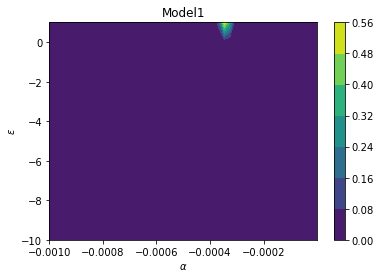

In [301]:
posterior_plot = plt.contourf(a1, e1, post1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\epsilon$')
plt.title('Model1')
plt.colorbar(posterior_plot)

In [282]:
# M2
# a: aplha;     b: beta     e: epsilon.

# prior
a2 = np.linspace(3e-9, 6e-9, 10)
b2 = np.linspace(-4.25e-12, -3e-12, 10)
e2 = np.linspace(-10, 1, 12)

# likelihood
def likeli2(a, b, e, data=df_HT):
    df = data.copy()
    df['sec'] = df['day']*861641
    # record the expected value of d_m2(t)
    df['d_m2'] = df['sec'] * a + df['sec']**2 * b
    # update sigma
    df.loc[df['y_err']==-99, 'y_err'] = 10**e * df['d_m2']
    # to calc guassian
    df['expo'] = -(df['y'] - df['d_m2'])**2 / df['y_err']**2 / 2
    df['denominator'] = (2*np.pi)**.5 * df['y_err']

    expo_sum = np.sum(df['expo'])
    deno_prod = np.product(df['denominator'])
    return expo_sum, df, np.exp(expo_sum) / deno_prod

# as uniform prior, posterior is actually prop to likeli
def posterior2(a, b, e):
    post = [[[likeli2(i,j,k)[0] for i in a] for j in b] for k in e]
    sum = np.sum(post)
    return np.divide(post, sum)

In [283]:
post2 = posterior2(a2, b2, e2)

In [293]:
post2

array([[[9.88930440e-03, 9.88930440e-03, 9.88930440e-03, ...,
         9.88930440e-03, 9.88930440e-03, 9.88930440e-03],
        [9.88921559e-03, 9.88921559e-03, 9.88921559e-03, ...,
         9.88921559e-03, 9.88921559e-03, 9.88921559e-03],
        [9.88912972e-03, 9.88912972e-03, 9.88912972e-03, ...,
         9.88912972e-03, 9.88912972e-03, 9.88912972e-03],
        ...,
        [9.88874456e-03, 9.88874456e-03, 9.88874456e-03, ...,
         9.88874456e-03, 9.88874456e-03, 9.88874456e-03],
        [9.88867635e-03, 9.88867635e-03, 9.88867635e-03, ...,
         9.88867635e-03, 9.88867635e-03, 9.88867635e-03],
        [9.88861109e-03, 9.88861109e-03, 9.88861109e-03, ...,
         9.88861109e-03, 9.88861109e-03, 9.88861109e-03]],

       [[1.00259804e-04, 1.00259804e-04, 1.00259804e-04, ...,
         1.00259803e-04, 1.00259803e-04, 1.00259803e-04],
        [1.00171045e-04, 1.00171045e-04, 1.00171044e-04, ...,
         1.00171044e-04, 1.00171044e-04, 1.00171044e-04],
        [1.00085234e-04, 

__Exercise__: Plot the marginalized distributions for $\varepsilon$ for both $\mathcal{M}_1$ and $\mathcal{M}_2$. There's no need to do a fancy numerical integral---it's sufficient to simply sum up the arrays along appropriate axes and to multiply by the appropriate differential elements like $d\alpha$ (or some $\Delta \alpha$, since this is a discrete numerical approximation).

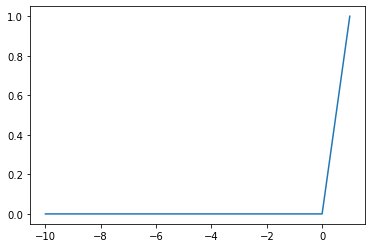

In [295]:
# M1
plt.plot(e1, [np.sum(i) for i in post1])
plt.show()

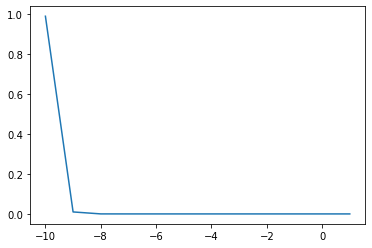

In [296]:
# M1
plt.plot(e2, [np.sum(i) for i in post2])
plt.show()

You should find that the data really does prefer a particular value for $\varepsilon$, so it's possible to get a sense for the error bars from the data! This may seem like magic---how can we figure out the error bars with no error information to begin with? What's really happening is that our analysis is using the scatter of our data points. Imagine I gave you a bunch of points with no error bars and asked you to fit a straight line through them. You could probably look at the distance between your best-fit line and the data points and roughly guess how big the error bars are. This is essentially what's going on here, in a more statistically disciplined fashion. In general, it's best if you have accurately estimated error bars from your measurements that you can just use. But this is a handy trick if you're in a pinch. Another interesting technique is to multiply all parameters with some parameter $\eta$, such that $\sigma_i \rightarrow \eta \sigma_i$. This new parameter is now another free parameter in our fitting exercise. If the posterior is peaked around $\eta \approx 1$, then the errors have been correctly estimated. If $\eta > 1$, the errors have been underestimated.

__Question__: Compare $p \left(\varepsilon | \mathbf{d}, \mathcal{M}_1 \right)$ and $p \left(\varepsilon | \mathbf{d}, \mathcal{M}_2 \right)$. Why do you think this is? (Hint: look at the data. Just from eyeballing the results, do you think $\mathcal{M}_1$ is likely to be a good model? It may also help to do the next two questions before answering this)

## Ans
M2,as it has higher evidence, i.e. the $p \left(\varepsilon_{mean} | \mathbf{d}, \mathcal{M} \right)$ 

Ultimately, $\varepsilon$ is a nuisance parameter, so while it's interesting to look at to help us understand the data, what we really care about are parameters like $\alpha$ and $\beta$.

__Exercise__: Marginalize over $\varepsilon$ to compute $p \left(\alpha, \beta | \mathbf{d}, \mathcal{M}_2 \right)$. Make a contour plot of your results. Are the best-fit values of $\alpha$ and $\beta$ correlated with one another?

In [304]:
from scipy.optimize import curve_fit

f_m1 = lambda x,a: a*x 
f_m2 = lambda x,a,b: a*x+b*x**2

df_HT['sec'] = 86164.1*df_HT['day']
a1, _ = curve_fit(f_m1, df_HT['sec'], df_HT['y'])
ppot, _ = curve_fit(f_m2, df_HT['sec'], df_HT['y'])
a2, b2 = ppot

a1[0],a2,b2

(-2.805282070115243e-08, 4.193248035642144e-09, -4.268708935452204e-17)

__Exercise__: Find the values for $\alpha$, $\beta$, and $\varepsilon$ that maximize the posterior for the two models (these values are known as MAP or "maximum *a posteriori*" values). Use these values to plot your best-fit curves, as well as the original data points and their error bars (now that you have them for every point).

In [173]:
popt, _ = curve_fit(likeli, xspace, h)
    lamb = popt[0]
    c = popt[1]
    if doPlot:
        plt.hist(xdata, bins=bins)
        plt.plot(xspace, likeli(xspace, lamb, c))
        plt.title('data')
        plt.xlabel('x/cm')
        plt.ylabel('numbers of data points')
        plt.show()

### Model selection

Let's now compute the Bayesian evidences to help us decide on an appropriate model.

__Exercise__: Compute $p(\mathbf{d} | \mathcal{M}_1)$ and $p(\mathbf{d} | \mathcal{M}_2)$. If you make use of intermediate results you had from before, this should just be a matter of doing a numerical integral over an array you already have. (As before, though, there's no need to use a fancy numerical integration technique. Riemann sums are fine).

In [174]:
## Your code here

How lopsided do the evidences need to be in order for one to favour one model over another? There's no hard and fast rule, but everyone seems to quote the (arbitrary) rules of thumb written by [Kass & Raftery (1995)](https://www.stat.washington.edu/raftery/Research/PDF/kass1995.pdf), who suggest the following:

|  $\frac{p(\mathbf{d} | \mathcal{M}_2)}{p(\mathbf{d} | \mathcal{M}_1)}$  | Evidence against $\mathcal{M}_1$  |
|---|---|
| 1 to 3.2  |  Not worth more than a bare mention |
|  3.2 to 10 | Substantial  |
|  10 to 100 |  Strong |
|  > 100 |  Decisive |


__Question__: Which model is favoured?

In [175]:
## Your code here

## Discussion

In completing this exercise, you probably found that with a reasonably fine ``np.linspace`` grid, it took a little time for your code to run. This problem gets worse and worse as we include more and more parameters in our model because of what's known as "the curse of dimensionality". For example, if we have two parameters $\alpha$ and $\beta$ and we want to evaluate the posterior on a grid with $100$ points along the $\alpha$ axis and $100$ points along the $\beta$ axis, we end up having to evaluate $N = 100^2$ points. But if we had a $12$ free parameters, we would need to evaluate $N = 100^{12}$ points! This is not very practical from a computational standpoint. Next lecture we will begin learning about __*Markov Chain Monte Carlo*__ techniques that allow us to bypass this problem.

## Submitting your work

Don't forget to push a copy of your completed notebook to your Github repo for marking!